### Test trained model on unseen data

In [1]:
# Basic setup
import os
os.chdir('../')
import logging
import numpy as np
import pytorch_lightning as pl
import pandas as pd
import scanpy as sc
logging.basicConfig(
        level=logging.INFO,
        format='%(asctime)s - %(levelname)s - %(message)s'
    )
%load_ext autoreload
%autoreload 0

# assign number of cpus to use as data loaders
n_cpus = 10
seed = 42

# define label in .obs to classify
cls_label = 'cls_label'
batch_key = 'dataset'

/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_mtx from `

In [50]:
# Set model and training data paths
version_dir = '/home/xlv0877/proj_home/dl/models/run5/rl+kl+ce/lightning_logs/version_2'.rstrip('/')
model_dir = os.path.join(version_dir, 'model')
adata_p = '/home/xlv0877/proj_home/dl/data/model_set.h5ad'
latent_p = os.path.join(version_dir, 'latent.h5ad')

#### Load pre-trained model

In [51]:
from src.models._jedvi import JEDVI

adata = sc.read(adata_p)
model = JEDVI.load(model_dir, adata)
model

INFO     File /home/xlv0877/proj_home/dl/models/run5/rl+kl+ce/lightning_logs/version_2/model/model.pt already      
         downloaded                                                                                                


2025-07-03 12:23:06,683 - INFO - Converting adata.X to csr matrix to boost training efficiency.


<class 'src.models._jedvi.JEDVI'> Model with the following params: 
n_classes: 141, 
Training status: Trained

#### Load test data

In [52]:
test_p = 'data/test.h5ad'
test_ad = sc.read(test_p)

In [53]:
shared_perturbations = set(adata.obs.perturbation.unique()).intersection(test_ad.obs.perturbation.unique())
logging.info(f'Found {len(shared_perturbations)} shared perturbations between training and testing.')

2025-07-03 12:23:24,288 - INFO - Found 7 shared perturbations between training and testing.


In [54]:
# Polish data TODO: take datasets from pipeline (will be in correct format so this is not needed)
# Remove control class from adata
test_ad._inplace_subset_obs(test_ad.obs.perturbation!='control')

In [55]:
# define all labels to classify on
if 'perturbation_direction' in adata.obs.columns:
    logging.info('Using perturbation direction to classify')
    cls_labels = ['perturbation_direction', 'perturbation']
else:
    cls_labels = ['celltype', 'perturbation_type', 'perturbation']
# define label in .obs to classify
cls_label = 'cls_label'
batch_key = 'dataset'
# create classification label
test_ad.obs['cls_label'] = test_ad.obs[cls_labels].agg(';'.join, axis=1)
test_ad.obs['dataset'] = 'ReplogleWeissman2022_K562_gwps'
test_ad.obs['celltype'] = 'lymphoblasts'

2025-07-03 12:23:29,263 - INFO - Using perturbation direction to classify


In [56]:
# Init test dataset with pre-trained model
model.setup_anndata(
    test_ad, labels_key=cls_label,
    batch_key=batch_key,
    categorical_covariate_keys=['celltype']
)

2025-07-03 12:23:31,240 - INFO - Converting adata.X to csr matrix to boost training efficiency.


In [57]:
# Create compatible test data for trained model
test_ad = model.create_test_data(test_ad)

2025-07-03 12:23:45,107 - INFO - Found 2089 missing genes in test data. Setting them to 0.


In [58]:
# Get latent representation of test data
test_ad.obsm['latent_z'] = model.get_latent_representation(adata=test_ad)

2025-07-03 12:23:46,657 - INFO - Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup


... storing 'celltype' as categorical
... storing 'dataset' as categorical
... storing 'cls_label' as categorical
... storing 'mode' as categorical


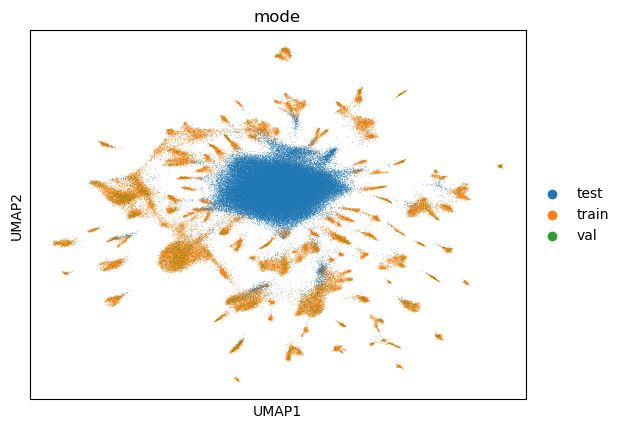

In [59]:
import anndata as ad
# Combine with existing latent space for training and validation split

latent = sc.read(latent_p)
test_ad.obs['mode'] = 'test'
tmp = ad.AnnData(test_ad.obsm['latent_z'], obs=test_ad.obs, var=None)
latent = ad.concat([latent, tmp])
sc.pp.neighbors(latent, use_rep='X')
sc.tl.umap(latent)
sc.pl.umap(latent, color='mode')

... storing 'cls_label' as categorical
... storing 'dataset' as categorical
... storing 'celltype' as categorical
... storing 'mode' as categorical
... storing 'cls_prediction' as categorical


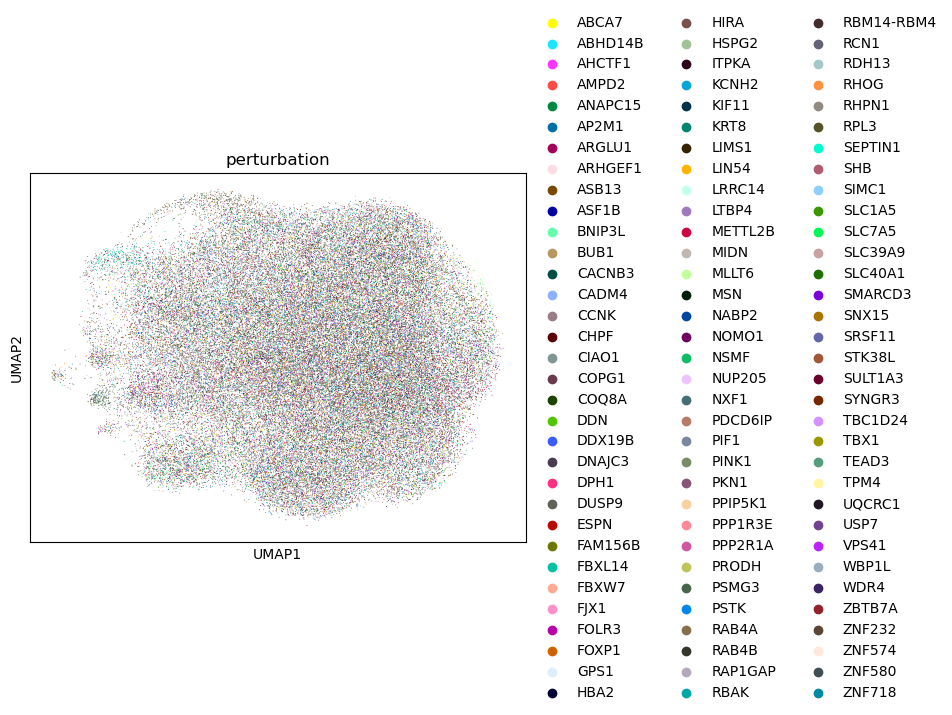

In [60]:
# Predict class labels (gene perturbations)
predictions, cz = model.predict(adata=test_ad, return_latent=True)
test_ad.obs['cls_prediction'] = predictions
test_ad.obsm['cz'] = cz
# plot classifier latent space embedding
sc.pp.neighbors(test_ad, use_rep='cz')
sc.tl.umap(test_ad)
sc.pl.umap(test_ad, color='perturbation')

In [61]:
from src.plotting import get_classification_report

summary, report = get_classification_report(test_ad, cls_label=cls_label, mode='test')

/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [63]:
report.sort_values('f1-score', ascending=False).head(10)

,precision,recall,f1-score,support,log_count,mode
neg;GPS1,0.135026,0.348733,0.194676,671.0,6.508769,test
neg;RPL3,0.256364,0.143658,0.184133,1963.0,7.582229,test
neg;ARGLU1,0.061397,0.475483,0.108751,673.0,6.511745,test
neg;SLC39A9,0.055529,0.438750,0.098582,800.0,6.684612,test
neg;ZNF574,0.047492,0.110592,0.066448,642.0,6.464588,test
neg;CIAO1,0.100917,0.017713,0.030137,621.0,6.431331,test
neg;PSMG3,0.291667,0.008850,0.017178,791.0,6.673298,test
neg;RBMX2,0.000000,0.000000,0.000000,0.0,-inf,test
neg;RBAK,0.000000,0.000000,0.000000,652.0,6.480045,test
neg;RARS,0.000000,0.000000,0.000000,0.0,-inf,test


In [74]:
soft_predictions = model.predict(adata=test_ad, return_latent=False, soft=True)

In [100]:
latent.obs['cls_score'] = np.max(soft_predictions, axis=1)

In [105]:
pl_df = soft_predictions.iloc[0:100,:].T.melt()

<Axes: xlabel='value', ylabel='cell_barcode'>

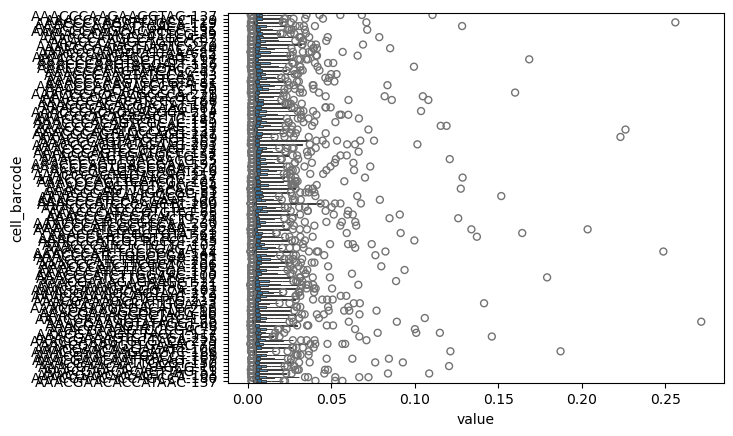

In [108]:
import seaborn as sns

sns.boxenplot(pl_df, x='value', y='cell_barcode')

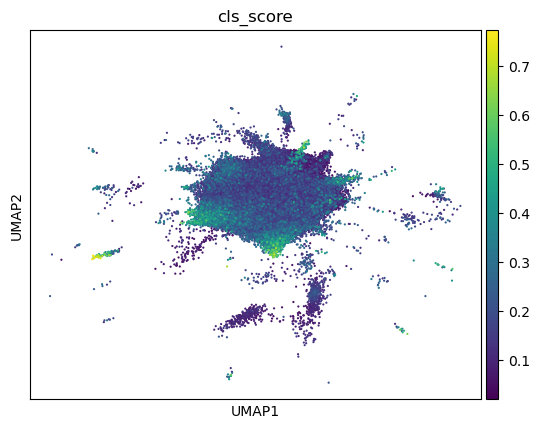

In [103]:
tmp = latent[latent.obs['mode']=='test'].copy()
sc.pl.umap(tmp, color=['cls_score'], s=10)

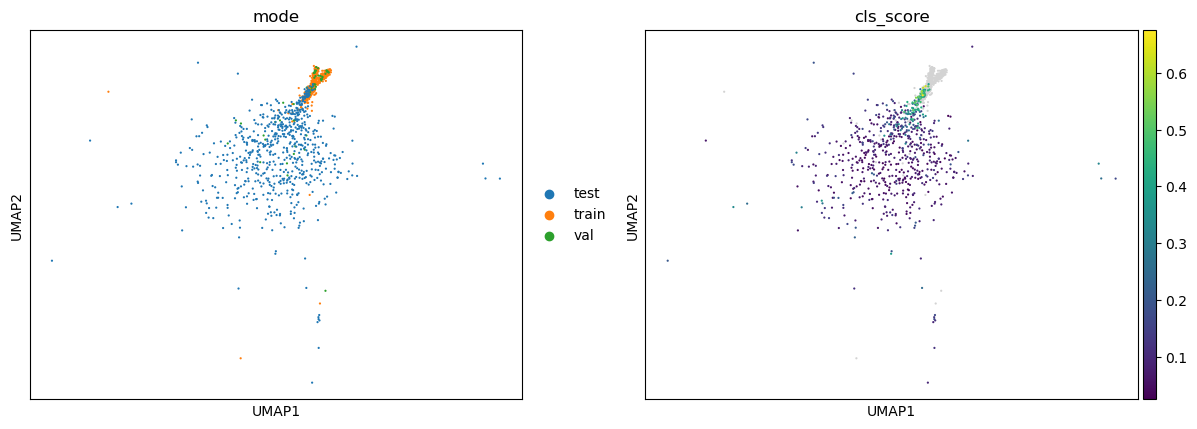

In [102]:
tmp = latent[latent.obs.perturbation=='GPS1'].copy()
sc.pl.umap(tmp, color=['mode', 'cls_score'], s=10)

In [64]:
report['f1-score'].max()

0.194675540765391

In [49]:
shared_perturbations

{'ARGLU1', 'CIAO1', 'GPS1', 'PSMG3', 'RPL3', 'SLC39A9', 'ZNF574'}

In [ ]:
from src.plotting import predict_novel, plot_model_results_mode, get_latest_tensor_dir
# Predict novel
test_ad.obs['perturbation_type'] = 'CRISPRi'
logging.info('Running model with novel test data.')
plt_dir = os.path.join(version_dir, 'plots')
predict_novel(gedvae, test_adata, 'cls_label', out_dir=version_dir, batch_key='dataset', emb_key=None)